In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
data_path = './data'
idlist_path = '/player_idlist.csv'
players_path = '/players'
season = '/2018-19'

In [3]:
idlist = pd.read_csv(data_path + season + idlist_path)

In [4]:
#create players
players = pd.DataFrame()
for index, row in idlist.iterrows():
    first_name = row['first_name']
    second_name = row['second_name']
    player_id = row['id']
    player_path = '/' + first_name + '_' + second_name + '_' + str(player_id)
    
    try:
        player = pd.read_csv(data_path + season + players_path + player_path + '/gw.csv')
    except FileNotFoundError:
        pass
    player['gw'] = np.arange(len(player)) + 1
    player['player_id'] = player_id
    players = pd.concat([players, player], axis=0)

In [5]:
#load teams data
teams = pd.read_csv(data_path + season + '/teams_raw.csv')
teams.rename(columns={'id': 'team_id'}, inplace=True)

#load element_types data
element_types = pd.read_csv(data_path + season + '/element_types_raw.csv')
element_types.drop(columns=['plural_name', 'plural_name_short'],inplace=True)
element_types.rename(columns={'id':'element_type_id', 'singular_name': 'position_name', 'singular_name_short' : 'position_short'}, inplace=True)

#load player_cleaned data
cleaned_players = pd.read_csv(data_path + season + '/cleaned_players.csv')
cleaned_players.rename(columns={'id':'player_id'}, inplace=True)

In [6]:
#prepare players data
players = pd.merge(players, cleaned_players.loc[:,['player_id', 'first_name', 'second_name', 'team', 'element_type']], on='player_id')

#merge team name
players = pd.merge(players, teams.loc[:, ['team_id', 'name']], left_on='team', right_on='team_id')
players.drop(columns=['team_id', 'team'], inplace=True)
players.rename(columns={'name':'team'}, inplace=True)

#merge element type 
players = pd.merge(players, element_types, left_on='element_type', right_on='element_type_id')
players.drop(columns=['element_type', 'element_type_id'], inplace=True)
players.rename(columns={'position_name':'position'}, inplace=True)

#rename total_points to points
players.rename(columns={'total_points':'points'}, inplace=True)

In [7]:
#swap columns
players = pd.concat([players.iloc[:, -7:], players.iloc[:, :-7]], axis=1)
#add features
#players['goal_consistency'] = players['goals_scored'] > 0
#players['assist_consistency'] = players['assists'] > 0
#players['goals_and_assists'] = players['goals_scored'] + players['assists']
#players['goal_or_assist_consistency'] = players['goal_consistency'] | players['assist_consistency']

In [8]:
def stat_by_was_home(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    home = player.loc[player.was_home == True, :]
    away = player.loc[player.was_home == False, :]
    return home[stat].aggregate(agg), away[stat].aggregate(agg)

In [9]:
def team_mates_stat_for_gw(player_id, gw, stat, agg):
    team = players.loc[players.player_id == player_id, ['team']].iloc[0].values[0]
    is_other = players['player_id'] != player_id
    is_same_team = players['team'] == team
    is_same_gw = players['gw'] == gw
    is_played = players['minutes'] > 50
    other = players.loc[is_other & is_same_team & is_same_gw & is_played, :]
    return other[stat].aggregate(agg)

def team_mates_stat_for_all_gws(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    gws = player['gw']
    results = pd.Series(list(map(lambda x: team_mates_stat_for_gw(player_id, x, stat, agg), gws)))
    return list(results)

def team_stat_for_n_gw_before(team, stat, agg, current_gw, n_gw_before):
    if(current_gw > n_gw_before):
        gw_range = np.arange(current_gw - n_gw_before, current_gw)
        team_players = players.loc[([gw in gw_range for gw in players.gw]) & (players.team == team) & (players.minutes > 50), :]
        result = team_players[stat].aggregate(agg)
        return result
    else:
        return np.nan
    
def get_opponent_team(player_id, gw):
    opponent_team_id = players.loc[(players.player_id == player_id) & (players.gw == gw), ['opponent_team']].iloc[0].values[0]
    opponent_team = teams.loc[teams.team_id == opponent_team_id, 'name'].values[0]
    return opponent_team

def opponent_players_stat_n_gw_before_for_all_gws(player_id, stat, agg, n_gw_before):
    player = players.loc[players.player_id == player_id, :]
    gws = player['gw']
    results = pd.Series(list(map(lambda x: team_stat_for_n_gw_before(get_opponent_team(player_id,x), stat, agg, x, n_gw_before), gws)))
    return list(results)

def create_new_stat(player, new_stat):
    player_id = player.iloc[0]['player_id']
    if new_stat == 'goal_consistency':
        return player['goals_scored'] > 0
    elif new_stat == 'assist_consistency':
        return player['assists'] > 0
    elif new_stat == 'goals_and_assists':
        return player['goals_scored'] + player['assists']
    elif new_stat == 'goal_or_assist_consistency':
        return (player['goals_scored'] > 0) | (player['assists'] > 0)
    elif new_stat == 'total_team_mates_ict_index':
        return team_mates_stat_for_all_gws(player_id=player_id, stat='ict_index', agg=np.sum)
    elif new_stat == 'mean_team_mates_ict_index':
        return team_mates_stat_for_all_gws(player_id=player_id, stat='ict_index', agg=np.mean)
    elif new_stat == 'total_opponent_players_ict_index':
        return opponent_players_stat_for_all_gws(player_id=player_id, stat='ict_index', agg=np.sum)
    elif new_stat == 'mean_opponent_players_ict_index':
        return opponent_players_stat_for_all_gws(player_id=player_id, stat='ict_index', agg=np.mean)

def player_stat_in_last_n_gw(player_id, stat, aggregate, n_gw):
    player = players.loc[players.player_id == player_id, :]
    if stat not in player.columns.values:
        player[stat] = create_new_stat(player, stat)
    
    if(n_gw == 1):
            return player[stat].shift(1)
    else:
            return player[stat].shift().rolling(min_periods=n_gw, window=n_gw).aggregate(aggregate)
    
    #if(player.shape[0] > n_gw):
    #    if(n_gw == 1):
    #        return player[stat].shift(1)
    #    else:
    #        return player[stat].shift().rolling(min_periods=n_gw, window=n_gw).aggregate(aggregate)
    #else:
    #    return pd.Series(np.full(player.shape[0], np.nan))

def stat_last_n_gw(player_id, stat, aggregate, n_gw):
    player = players.loc[players.player_id == player_id, :]
    
    if stat not in player.columns.values:
        player[stat] = create_new_stat(player, stat)
    
    last_n_row = player.iloc[-n_gw:, :]
    return [last_n_row[stat].aggregate(aggregate)]

def create_X_train(player_id, predictors):
    result = pd.DataFrame()
    for predictor in predictors:
        if predictor == 'total_goals_scored_1_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goals_scored_2_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=2)   
        elif predictor == 'total_goals_scored_3_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_assists_1_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='assists', aggregate=np.sum, n_gw=1)    
        elif predictor == 'total_assists_2_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='assists', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_assists_3_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='assists', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_goals_and_assists_1_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goals_and_assists_2_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_goals_and_assists_3_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=3) 
        
        elif predictor == 'total_goal_consistencies_1_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goal_consistencies_2_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_goal_consistencies_3_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_goal_or_assist_consistencies_1_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goal_or_assist_consistencies_2_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_goal_or_assist_consistencies_3_gw_before':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_total_team_mates_ict_index_1_gw_bebore':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='total_team_mates_ict_index', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_total_team_mates_ict_index_2_gw_bebore':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='total_team_mates_ict_index', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_total_team_mates_ict_index_3_gw_bebore':
            result[predictor] = player_stat_in_last_n_gw(player_id=player_id, stat='total_team_mates_ict_index', aggregate=np.sum, n_gw=3)
        
        elif predictor == 'total_total_team_opponent_players_ict_index_1_gw_bebore':
            result[predictor] = opponent_players_stat_n_gw_before_for_all_gws(player_id=player_id,stat='ict_index', agg=np.sum, n_gw_before=1)
        elif predictor == 'total_total_team_opponent_players_ict_index_2_gw_bebore':
            result[predictor] = opponent_players_stat_n_gw_before_for_all_gws(player_id=player_id,stat='ict_index', agg=np.sum, n_gw_before=2)
        elif predictor == 'total_total_team_opponent_players_ict_index_3_gw_bebore':
            result[predictor] = opponent_players_stat_n_gw_before_for_all_gws(player_id=player_id,stat='ict_index', agg=np.sum, n_gw_before=3)
            
        elif predictor == 'was_home':
            result[predictor] = players.loc[players.player_id == player_id, 'was_home']
        
    return result 

def create_y_train(player_id):
    player = players.loc[players.player_id == player_id, :]
    return player.goals_scored > 0

def create_X_test(player_id, predictors, **kwargs):
    result = pd.DataFrame()
    for predictor in predictors:
        if predictor == 'total_goals_scored_1_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goals_scored_2_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=2)   
        elif predictor == 'total_goals_scored_3_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_assists_1_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='assists', aggregate=np.sum, n_gw=1)    
        elif predictor == 'total_assists_2_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='assists', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_assists_3_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='assists', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_goals_and_assists_1_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goals_and_assists_2_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_goals_and_assists_3_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=3) 
        
        elif predictor == 'total_goal_consistencies_1_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goal_consistencies_2_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_goal_consistencies_3_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_goal_or_assist_consistencies_1_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_goal_or_assist_consistencies_2_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_goal_or_assist_consistencies_3_gw_before':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'total_total_team_mates_ict_index_1_gw_bebore':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='total_team_mates_ict_index', aggregate=np.sum, n_gw=1)
        elif predictor == 'total_total_team_mates_ict_index_2_gw_bebore':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='total_team_mates_ict_index', aggregate=np.sum, n_gw=2)
        elif predictor == 'total_total_team_mates_ict_index_3_gw_bebore':
            result[predictor] = stat_last_n_gw(player_id=player_id, stat='total_team_mates_ict_index', aggregate=np.sum, n_gw=3)
            
        elif predictor == 'was_home':
            result[predictor] = [kwargs['was_home']]
                          
        elif predictor == 'total_total_team_opponent_players_ict_index_1_gw_bebore':
            result[predictor] = [team_stat_for_n_gw_before(team=kwargs['opponent_team'], stat='ict_index', agg=np.sum, current_gw=kwargs['current_gw'], n_gw_before=1)]
        elif predictor == 'total_total_team_opponent_players_ict_index_2_gw_bebore':
            result[predictor] = [team_stat_for_n_gw_before(team=kwargs['opponent_team'], stat='ict_index', agg=np.sum, current_gw=kwargs['current_gw'], n_gw_before=2)]
        elif predictor == 'total_total_team_opponent_players_ict_index_3_gw_bebore':
            result[predictor] = [team_stat_for_n_gw_before(team=kwargs['opponent_team'], stat='ict_index', agg=np.sum, current_gw=kwargs['current_gw'], n_gw_before=3)]      
            
    return result 



In [10]:
top_scorers = players.groupby('player_id', as_index=False)['goals_scored'].sum().sort_values('goals_scored',ascending=False)[:10]
top_scorers

,player_id,goals_scored
252,253,16
22,23,14
371,372,14
42,43,10
121,122,10
269,270,10
279,280,10
256,257,9
250,251,9
392,393,9


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Pierre-Emerick Aubameyang
player_id = 23
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Cardiff')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [12]:
#Harry_Kane
player_id = 372
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Watford')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[0., 1.]])

In [13]:
#Mohamed_Salah
player_id = 253
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Leicester')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[0., 1.]])

In [14]:
#mane
player_id = 251
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Leicester')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [15]:
#Eden_Hazard
player_id = 122
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
#predictors = [ 'total_goals_scored_3_gw_before' +  'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Bournemouth')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[0., 1.]])

In [16]:
#Sergio_Agüero
player_id = 280
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Newcastle')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [17]:
#Richarlison_de Andrade
player_id = 393
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Huddersfield')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [18]:
#Callum_Wilson
player_id = 43
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Chelsea')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[0., 1.]])

In [19]:
#Anthony_Martial
player_id = 301
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Burnley')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [20]:
#Paul Pogba
player_id = 302
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Burnley')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [21]:
#Macus Rashford
player_id = 305
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Burnley')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [22]:
#Redmond
player_id = 343
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Crystal Palace')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [23]:
#Jiménez
player_id = 437
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='West Ham')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[0., 1.]])

In [24]:
#Sigurdsson
player_id = 172
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Huddersfield')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [25]:
#Sane
player_id = 275
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Newcastle')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [26]:
#David Silva
player_id = 271
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Newcastle')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [27]:
#Sterling
player_id = 270
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Newcastle')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[0., 1.]])

In [28]:
#Kanté
player_id = 126
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Bournemouth')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [29]:
#Pedro
player_id = 125
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Bournemmouth')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[0., 1.]])

In [30]:
#Willian
player_id = 124
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Bournemmouth')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [32]:
#Vardy
player_id = 234
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=False, current_gw=24, opponent_team='Liverpool')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [33]:
#Son
player_id = 367
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Watford')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [34]:
#Mitrovic
player_id = 480
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before' + 'total_total_team_mates_ict_index_1_gw_bebore' + 'total_total_team_mates_ict_index_12_gw_bebore' + 'total_total_team_mates_ict_index_3_gw_bebore', 'total_total_team_opponent_players_ict_index_1_gw_bebore', 'total_total_team_opponent_players_ict_index_2_gw_bebore', 'total_total_team_opponent_players_ict_index_3_gw_bebore', 'was_home']
X_train = create_X_train(player_id, predictors)
X_train.fillna(0, inplace=True)
y_train = create_y_train(player_id)
X_test = create_X_test(player_id, predictors, was_home=True, current_gw=24, opponent_team='Brighton')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.predict_proba(X_test)

array([[1., 0.]])

In [43]:
d = pd.DataFrame({
    'player' : ['Mitrovic', 'Son', 'Vardy', 'Willian', 'Pedro', 'Kanté', 'Sterling', 'David Silva', 'Sane', 'Sigurdsson', 'Jiménez', 'Redmond', 'Rashford', 'Pogba', 'Martial', 'Richarlison_de', 'Wilson', 'Agüero', 'Hazard', 'mane', 'Salah', 'Kane', 'Aubameyang'],
    'negative': [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
    'positive' : [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]
})
d.to_csv('./report/gw24.csv', index=False)

In [37]:
predictors = ['total_goals_scored_1_gw_before', 'total_goals_scored_2_gw_before', 'total_goals_scored_3_gw_before']

def feature_importance_of_player(player_id):
    tree_clf = DecisionTreeClassifier()
    X_train = create_X_train(player_id=player_id, predictors=predictors)
    X_train.fillna(0, inplace=True)
    y_train = create_y_train(player_id=player_id)
    tree_clf.fit(X_train, y_train)
    return list(zip(tree_clf.feature_importances_, predictors))

def scoring_prob_of_player(player_id):
    knn_clf = KNeighborsClassifier(n_neighbors=1)
    X_train = create_X_train(player_id=player_id, predictors=predictors)
    X_train.fillna(0, inplace=True)
    y_train = create_y_train(player_id=player_id)
    X_test = create_X_test(player_id=player_id, predictors=predictors)
    
    knn_clf.fit(X_train, y_train)
    return knn_clf.predict_proba(X_test)

In [38]:
def get_player_name(player_id):
    df = cleaned_players.loc[cleaned_players.player_id == player_id, ['first_name', 'second_name']]
    return df['first_name'].iloc[0] + '_' +df['second_name'].iloc[0]

top_scorers = players.groupby('player_id', as_index=False)['goals_scored'].sum().sort_values('goals_scored',ascending=False)[:10]

result = pd.DataFrame(columns=['player_id', 'name', 'no_goal_prob', 'has_goal_prob'])
for i, row in top_scorers.iterrows():
    probs = scoring_prob_of_player(row['player_id'])
    name = get_player_name(row['player_id'])
    d = {
        'player_id': row['player_id'],
        'name' : name,
        'no_goal_prob' : probs[0][0],
        'has_goal_prob' : probs[0][1],
    }
    
    result = result.append(d, ignore_index=True)

result    
    

,player_id,name,no_goal_prob,has_goal_prob
0,253,Mohamed_Salah,1.0,0.0
1,23,Pierre-Emerick_Aubameyang,0.0,1.0
2,372,Harry_Kane,0.0,1.0
3,43,Callum_Wilson,1.0,0.0
4,122,Eden_Hazard,1.0,0.0
5,270,Raheem_Sterling,0.0,1.0
6,280,Sergio_Agüero,1.0,0.0
7,257,Roberto_Firmino,1.0,0.0
8,251,Sadio_Mané,1.0,0.0
9,393,Richarlison_de Andrade,0.0,1.0


In [39]:
def plot_last_3_gws_stat_affects_has_goals(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    player['has_goal'] = player['goals_scored'] > 0
    player[stat + '_1_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 1)
    player[stat + '_2_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 2)
    player[stat + '_3_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 3)

    has_goal = player.loc[player.has_goal, :]
    no_goal = player.loc[~(player.has_goal), :]

    plt.figure(figsize=(20, 5))
    
    for i in range(1, 4):
        #plot last n GWs stat
        x1 = has_goal[f"{stat}_{i}_gw_before"].dropna()
        x2 = no_goal[f"{stat}_{i}_gw_before"].dropna()

        lower = player[f"{stat}_{i}_gw_before"].min()
        upper = player[f"{stat}_{i}_gw_before"].max()

        bins = np.arange(lower, upper + 2, 1)

        plt.subplot(1, 3, i)
        plt.hist([x1, x2], label=['has_goals', 'no_goal'], bins=bins, histtype='bar', align='left')
        plt.title(f"{stat} last {i} GWs distributtion")
        plt.xlabel(f"{stat} last {i} GWs")
        plt.ylabel('Number of GWs')
        plt.xticks(bins)
        plt.legend()
    plt.show()
    

def plot_last_3_gws_stat_affects_more_than_10_points(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    player['more_than_10_points'] = player['points'] >= 8
    player[stat + '_1_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 1)
    player[stat + '_2_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 2)
    player[stat + '_3_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 3)

    has_effect = player.loc[player.more_than_10_points, :]
    no_effect = player.loc[~(player.more_than_10_points), :]

    plt.figure(figsize=(20, 5))
    
    for i in range(1, 4):
        #plot last n GWs stat
        x1 = has_effect[f"{stat}_{i}_gw_before"].dropna()
        x2 = no_effect[f"{stat}_{i}_gw_before"].dropna()

        lower = player[f"{stat}_{i}_gw_before"].min()
        upper = player[f"{stat}_{i}_gw_before"].max()

        bins = np.arange(lower, upper + 2, 1)

        plt.subplot(1, 3, i)
        plt.hist([x1, x2], label=['more_than_10_points', 'no_more_than_10_points'], bins=bins, histtype='bar', align='left')
        plt.title(f"{stat} last {i} GWs distributtion")
        plt.xlabel(f"{stat} last {i} GWs")
        plt.ylabel('Number of GWs')
        plt.xticks(bins)
        plt.legend()
    plt.show()
    
def plot_stat_by_was_home(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    grouped = player.groupby('was_home', as_index=False)[stat].agg(agg)
    home_stat = grouped.loc[grouped.was_home, stat]
    away_stat = grouped.loc[~grouped.was_home, stat]
    
    ind = np.arange(1) 
    width = 0.5
    plt.figure(figsize=(8, 7))
    plt.bar(ind, home_stat.values, width=width, align='center')
    plt.bar(ind + width, away_stat.values, width=width, align='center')
    plt.title(stat + ' by was home')
    plt.ylabel('Number of ' + stat)
    plt.xticks([0, 0.5], ['home', 'away'])
    plt.show()

## Is total historical goals affect current goal consistency?

Salah


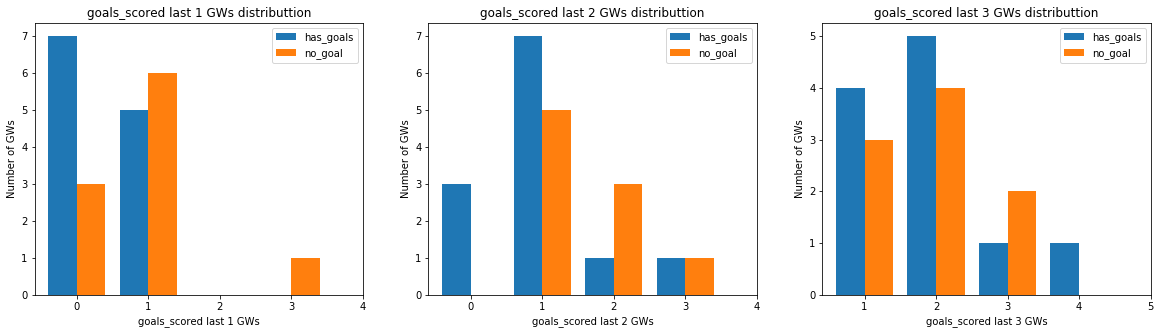

In [40]:
df = players.copy()
total_goals_grouped_by_player_id = df.groupby(df.player_id, as_index=False)['goals_scored'].sum()
total_goals_grouped_by_player_id = pd.merge(cleaned_players.loc[:, ['player_id', 'second_name']], total_goals_grouped_by_player_id, on='player_id')

top_scorers = total_goals_grouped_by_player_id.sort_values('goals_scored', ascending=False)[:1]

for index, row in top_scorers.iterrows():
    print(row['second_name'])
    plot_last_3_gws_stat_affects_has_goals(row['player_id'], 'goals_scored', np.sum)